<a href="https://colab.research.google.com/github/rbbh/Forecasting-Time-Series-with-Algorithm-Ensembling/blob/master/SVR_%2B_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [67]:
from google.colab import files
uploaded = files.upload()

Saving electric.txt to electric (2).txt


In [0]:
import io
import pandas as pd

# Un-comment the line for the data base that
# you want to predict

#data = pd.read_csv(io.BytesIO(uploaded['airlines2.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['DadosONS.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['carsales.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['coloradoRiver.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['accidentalDeathUSA.txt']))
data = pd.read_csv(io.BytesIO(uploaded['electric.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['gas.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['lakeerie.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['milk.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['redwine.txt']))

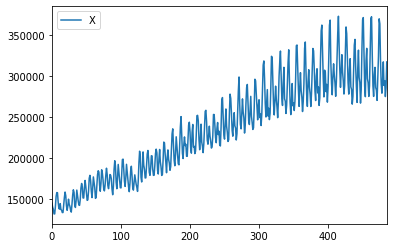

In [69]:
data.plot()


In [70]:
len(data)

486

In [72]:
#Normalizing the data

data_n = data.copy()
data_n = (data - data.min())/(data.max() - data.min())
print(data_n)

            X
0    0.054339
1    0.033843
2    0.023719
3    0.000041
4    0.000000
..        ...
481  0.650083
482  0.674132
483  0.593678
484  0.638636
485  0.768843

[486 rows x 1 columns]


In [73]:
# TODO: Create function for the Lag used for the prediction
# We will use 12 for the lag dimension if the series repeats 
# itself annually, 3 if it is trimestrial etc.

# Note: For the "ONS" data base, make "dimensions" = 3
# NOTE: For the "Milk" data base, make "dimensions" = 24

dimensions = 12
data_cn = pd.concat([data_n.shift(i) for i in range(0 + dimensions + 1)], axis = 1)

print(data_cn)

            X         X         X  ...         X         X         X
0    0.054339       NaN       NaN  ...       NaN       NaN       NaN
1    0.033843  0.054339       NaN  ...       NaN       NaN       NaN
2    0.023719  0.033843  0.054339  ...       NaN       NaN       NaN
3    0.000041  0.023719  0.033843  ...       NaN       NaN       NaN
4    0.000000  0.000041  0.023719  ...       NaN       NaN       NaN
..        ...       ...       ...  ...       ...       ...       ...
481  0.650083  0.769091  0.678967  ...  0.574339  0.625000  0.639752
482  0.674132  0.650083  0.769091  ...  0.677934  0.574339  0.625000
483  0.593678  0.674132  0.650083  ...  0.797934  0.677934  0.574339
484  0.638636  0.593678  0.674132  ...  0.986983  0.797934  0.677934
485  0.768843  0.638636  0.593678  ...  0.961240  0.986983  0.797934

[486 rows x 13 columns]


In [74]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_cn.iloc[12:,1:]

y = data_cn.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))


95
95
284


In [0]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-3
    max_e = 1e-1
    min_e = 1e-8
    max_g = 1e3
    min_g = 1e-3
    
    # Initializing particles' positions randomly, inside
    # the search space
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles' parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize  
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    best_iter = np.zeros(iterations)

    # Initializing regression variables
    p_best_RGS = np.empty((n_particles), dtype = object);
    g_best_RGS = sys.maxsize

    

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):

        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # To un-normalize the data:
          # Multiply the values by
          # data.to_numpy().max()

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point, for that particle,
          # is less than its personal best point,
          # replace personal best
          if(mse < p_best_val[j]):   # mse < p_best_val[j]
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = mse
              
              p_best_RGS[j] = rgs
                           

              # The value below represents the current search coordinates for
              # the particle's current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]

              # Assigning Particle's current best configuration to the Group's best
              g_best = p_best[aux].copy()

              # Group best regressor:
              # the combination of C, Epsilon and Gamma
              # that computes the best fitting curve
              g_best_RGS = p_best_RGS[aux]

        
          rand1 = np.random.random()
          rand2 = np.random.random()

          # The variable below influences directly the particle's velocity.
          # It can either make it smaller or bigger. 
          w = inertia

          # The equation below represents Particle's velocity, which is
          # the rate of change in its position
          v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

          # Change in the Particle's position 
          c[j] = c[j] + v[j]

          # Below is a series of conditions that stop the particles from
          # leaving the search space
          if(c[j][2] < min_g):
            c[j][2] = min_g
          if(c[j][2] > max_g):
            c[j][2] = max_g
          if(c[j][1] < min_e):
            c[j][1] = min_e
          if(c[j][1] > max_e):
            c[j][1] = max_e
          if(c[j][0] < min_c):
            c[j][0] = min_c
          if(c[j][0] > max_c):
            c[j][0] = max_c
            
     
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
                
        print('Best value iteration # %d = %f\n'%(i, g_best_val))

    # Coordinates found after all the iterations
    print('Group Best configuration found: ')
    print(g_best)
    print('\n')
    print('Best Regressor:\n')
    print(g_best_RGS)
    print('\n')
    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test = g_best_RGS.predict(X_test)

    
    # Displaying actual values and predicted values for
    # Group's best configuration found overall
    print(color.BOLD + 'Predictions with the Population Best Value found:\n' + color.END)
    evaluate(predict_test)  
      


In [0]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [0]:
# Function that displays tridimensional plot
def plot(some_list):
 
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

  print('\n')
  print('\n')

In [0]:
def evaluate(predictions):

    from sklearn.metrics import mean_squared_error
    import statistics as st

    predict_test = predictions

    # To un-normalize the data:
    # Multiply the values by
    # data.to_numpy().max()

    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_test, predict_test)
    print('\n')
    print('\n')
    print('Mean Squared Error for the Test Set:\t %f' %mse)
    print('\n')
    print('\n')
    print('Predictions Average:\t %f' %((predict_test.sum()/len(predict_test))))
    print('\n')
    print('\n')
    print('Predictions Median:\t %f' %(st.median(predict_test)))
    print('\n')
    print('\n')

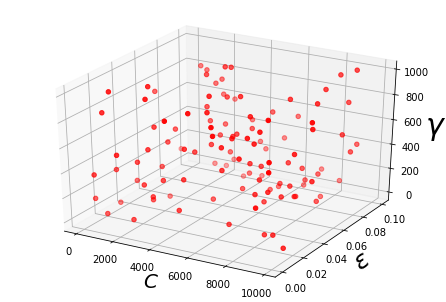





Best value iteration # 0 = 0.054964

Best value iteration # 1 = 0.001307

Best value iteration # 2 = 0.001307

Best value iteration # 3 = 0.001307

Best value iteration # 4 = 0.001307

Best value iteration # 5 = 0.001307

Best value iteration # 6 = 0.001307

Best value iteration # 7 = 0.001303

Best value iteration # 8 = 0.001303

Best value iteration # 9 = 0.001301

Best value iteration # 10 = 0.001301

Best value iteration # 11 = 0.001301

Best value iteration # 12 = 0.001301

Best value iteration # 13 = 0.001301

Best value iteration # 14 = 0.001301

Best value iteration # 15 = 0.001301

Best value iteration # 16 = 0.001301

Best value iteration # 17 = 0.001301

Best value iteration # 18 = 0.001301

Best value iteration # 19 = 0.001301

Best value iteration # 20 = 0.001301

Best value iteration # 21 = 0.001301

Best value iteration # 22 = 0.001301

Best value iteration # 23 = 0.001301

Best value iteration # 24 = 0.001301

Best value iteration # 25 = 0.001301

Best value iterati

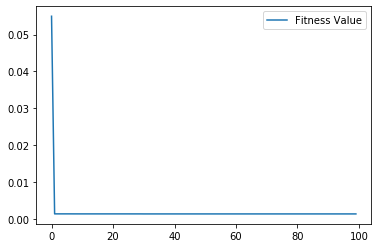

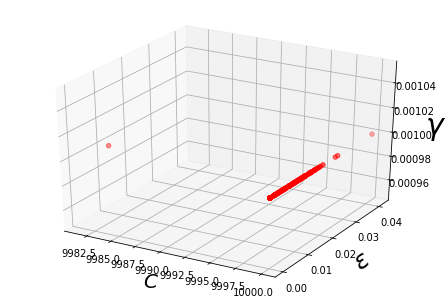





Predictions with the Population Best Value found:



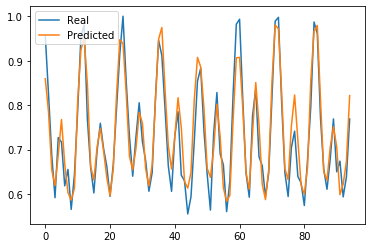





Mean Squared Error for the Test Set:	 0.001793




Predictions Average:	 0.740227




Predictions Median:	 0.707616






In [79]:
pso(120, 100, 3, 1)

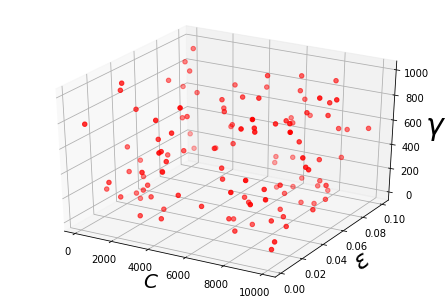





Best value iteration # 0 = 0.046599

Best value iteration # 1 = 0.001325

Best value iteration # 2 = 0.001313

Best value iteration # 3 = 0.001303

Best value iteration # 4 = 0.001303

Best value iteration # 5 = 0.001303

Best value iteration # 6 = 0.001303

Best value iteration # 7 = 0.001302

Best value iteration # 8 = 0.001302

Best value iteration # 9 = 0.001302

Best value iteration # 10 = 0.001302

Best value iteration # 11 = 0.001302

Best value iteration # 12 = 0.001302

Best value iteration # 13 = 0.001302

Best value iteration # 14 = 0.001302

Best value iteration # 15 = 0.001302

Best value iteration # 16 = 0.001302

Best value iteration # 17 = 0.001302

Best value iteration # 18 = 0.001299

Best value iteration # 19 = 0.001299

Best value iteration # 20 = 0.001299

Best value iteration # 21 = 0.001299

Best value iteration # 22 = 0.001299

Best value iteration # 23 = 0.001298

Best value iteration # 24 = 0.001298

Best value iteration # 25 = 0.001298

Best value iterati

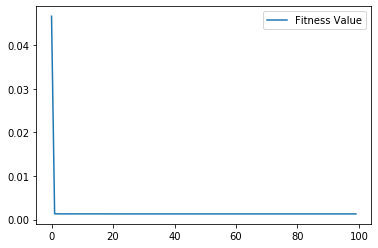

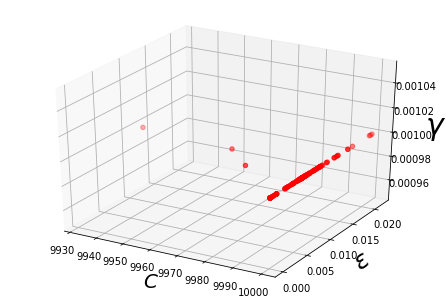





Predictions with the Population Best Value found:



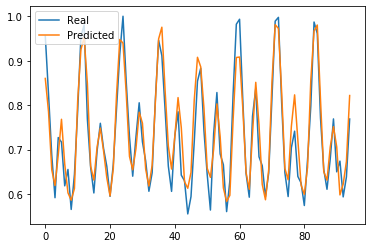





Mean Squared Error for the Test Set:	 0.001794




Predictions Average:	 0.740362




Predictions Median:	 0.707854






In [80]:
pso(120, 100, 3, 0.8)

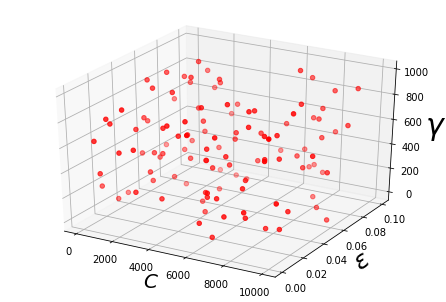





Best value iteration # 0 = 0.032346

Best value iteration # 1 = 0.001356

Best value iteration # 2 = 0.001318

Best value iteration # 3 = 0.001300

Best value iteration # 4 = 0.001300

Best value iteration # 5 = 0.001300

Best value iteration # 6 = 0.001300

Best value iteration # 7 = 0.001300

Best value iteration # 8 = 0.001300

Best value iteration # 9 = 0.001300

Best value iteration # 10 = 0.001300

Best value iteration # 11 = 0.001300

Best value iteration # 12 = 0.001300

Best value iteration # 13 = 0.001300

Best value iteration # 14 = 0.001300

Best value iteration # 15 = 0.001300

Best value iteration # 16 = 0.001300

Best value iteration # 17 = 0.001300

Best value iteration # 18 = 0.001300

Best value iteration # 19 = 0.001300

Best value iteration # 20 = 0.001300

Best value iteration # 21 = 0.001300

Best value iteration # 22 = 0.001300

Best value iteration # 23 = 0.001300

Best value iteration # 24 = 0.001300

Best value iteration # 25 = 0.001298

Best value iterati

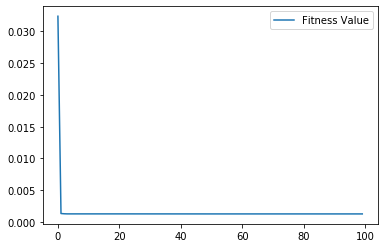

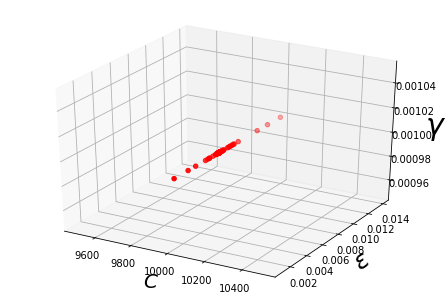





Predictions with the Population Best Value found:



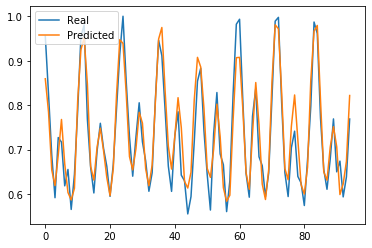





Mean Squared Error for the Test Set:	 0.001796




Predictions Average:	 0.740317




Predictions Median:	 0.707524






In [81]:
pso(120, 100, 3, 0.6)

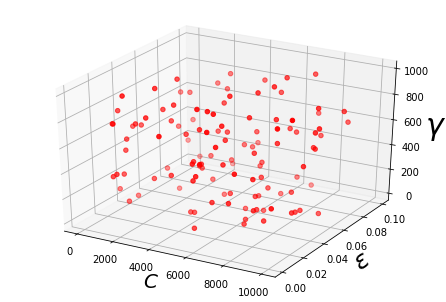





Best value iteration # 0 = 0.077641

Best value iteration # 1 = 0.001715

Best value iteration # 2 = 0.001715

Best value iteration # 3 = 0.001509

Best value iteration # 4 = 0.001458

Best value iteration # 5 = 0.001398

Best value iteration # 6 = 0.001337

Best value iteration # 7 = 0.001323

Best value iteration # 8 = 0.001319

Best value iteration # 9 = 0.001317

Best value iteration # 10 = 0.001312

Best value iteration # 11 = 0.001308

Best value iteration # 12 = 0.001308

Best value iteration # 13 = 0.001308

Best value iteration # 14 = 0.001308

Best value iteration # 15 = 0.001308

Best value iteration # 16 = 0.001303

Best value iteration # 17 = 0.001303

Best value iteration # 18 = 0.001303

Best value iteration # 19 = 0.001303

Best value iteration # 20 = 0.001302

Best value iteration # 21 = 0.001302

Best value iteration # 22 = 0.001302

Best value iteration # 23 = 0.001302

Best value iteration # 24 = 0.001302

Best value iteration # 25 = 0.001302

Best value iterati

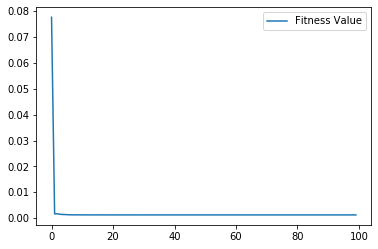

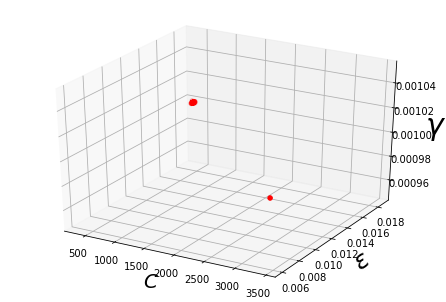





Predictions with the Population Best Value found:



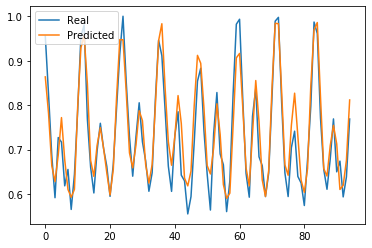





Mean Squared Error for the Test Set:	 0.001867




Predictions Average:	 0.743963




Predictions Median:	 0.717583






In [82]:
pso(120, 100, 3, 0.2)